# XGBoost Prediction
> https://www.kaggle.com/code/ysthehurricane/bitcoin-dogecoin-etc-price-prediction-xgboost/notebook

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

D:/kaggle/jpx-prediction\stock_list.csv
D:/kaggle/jpx-prediction\data_specifications\options_spec.csv
D:/kaggle/jpx-prediction\data_specifications\stock_fin_spec.csv
D:/kaggle/jpx-prediction\data_specifications\stock_list_spec.csv
D:/kaggle/jpx-prediction\data_specifications\stock_price_spec.csv
D:/kaggle/jpx-prediction\data_specifications\trades_spec.csv
D:/kaggle/jpx-prediction\example_test_files\financials.csv
D:/kaggle/jpx-prediction\example_test_files\options.csv
D:/kaggle/jpx-prediction\example_test_files\sample_submission.csv
D:/kaggle/jpx-prediction\example_test_files\secondary_stock_prices.csv
D:/kaggle/jpx-prediction\example_test_files\stock_prices.csv
D:/kaggle/jpx-prediction\example_test_files\trades.csv
D:/kaggle/jpx-prediction\jpx_tokyo_market_prediction\__init__.py
D:/kaggle/jpx-prediction\jpx_tokyo_market_prediction\competition.cpython-37m-x86_64-linux-gnu.so
D:/kaggle/jpx-prediction\supplemental_files\financials.csv
D:/kaggle/jpx-prediction\supplemental_files\options.c

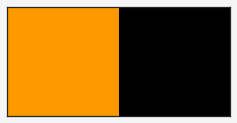

In [2]:
colors = ['#FF9900','#000000']
sns.set(palette=colors, font='Serif', style='white', rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})
sns.palplot(colors, size=2)
for dirname, _, filenames in os.walk('D:/kaggle/jpx-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
stonks = pd.read_csv("D:/kaggle/jpx-prediction/train_files/stock_prices.csv")
stonks

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


### Drop RowId

In [4]:
stonks.drop('RowId', axis=1, inplace=True)
stonks

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...
2332526,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


### Typecast Date String into Datetime

In [5]:
stonks['Date']=pd.to_datetime(stonks['Date'])
print("Minimum date value : {}".format(stonks['Date'].min()))
print("Maximum date value : {}".format(stonks['Date'].max()))

Minimum date value : 2017-01-04 00:00:00
Maximum date value : 2021-12-03 00:00:00


## Security 1301

In [6]:
data = stonks[stonks['SecuritiesCode']==1301].reset_index(drop=True)
data

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
2,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092
3,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100
4,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295
...,...,...,...,...,...,...,...,...,...,...,...
1197,2021-11-29,1301,2975.0,2984.0,2951.0,2951.0,14300,1.0,NaN,False,0.003793
1198,2021-11-30,1301,2953.0,2997.0,2900.0,2900.0,20500,1.0,NaN,False,0.007558
1199,2021-12-01,1301,2909.0,2936.0,2909.0,2911.0,10600,1.0,NaN,False,0.016706
1200,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689


### Check for NaN

In [7]:
data.isnull().sum()

Date                   0
SecuritiesCode         0
Open                   1
High                   1
Low                    1
Close                  1
Volume                 0
AdjustmentFactor       0
ExpectedDividend    1197
SupervisionFlag        0
Target                 0
dtype: int64

### Replace NaN with 0

In [8]:
data = data.fillna(0)

In [9]:
data.isnull().sum()

Date                0
SecuritiesCode      0
Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
ExpectedDividend    0
SupervisionFlag     0
Target              0
dtype: int64

Text(0.5, 1.0, 'Security Code 6474 Stock Value Changes Since 2017')

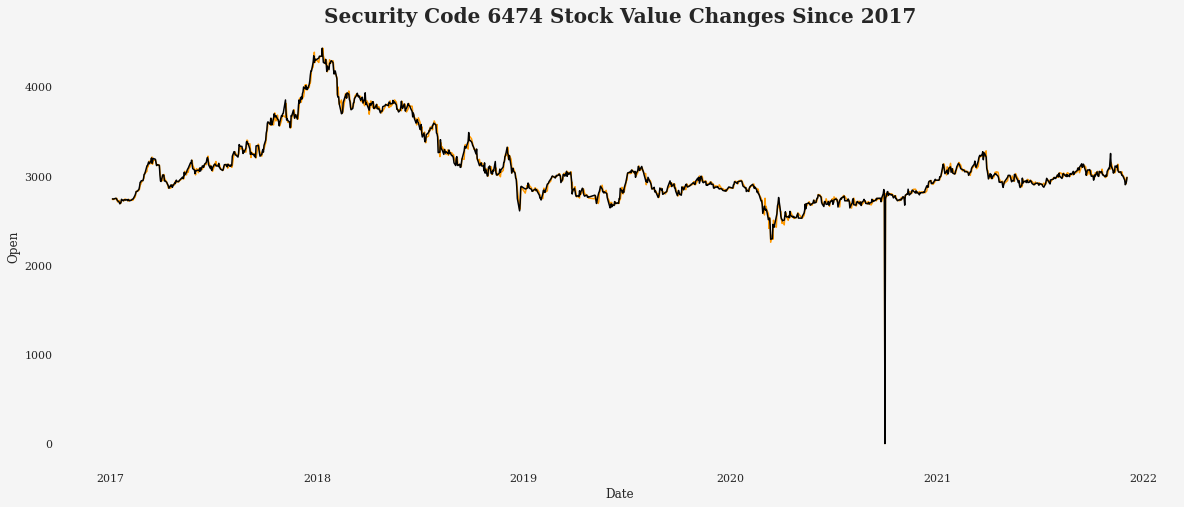

In [10]:
fig=plt.figure(figsize=(20,8))
ax=sns.lineplot(data=data, x='Date',y='Open')
ax=sns.lineplot(data=data, x='Date',y='Close', color=colors[1]);
for s in ['left','right','top','bottom']:
    ax.spines[s].set_visible(False)

plt.title("Security Code 6474 Stock Value Changes Since 2017", size=20, weight='bold')

## Predict Using XGBoost

In [11]:
X = data[["Open", 'Volume']]
y = data["Close"]
X, y

(        Open  Volume
 0     2734.0   31400
 1     2743.0   17900
 2     2734.0   19900
 3     2745.0   24200
 4     2748.0    9300
 ...      ...     ...
 1197  2975.0   14300
 1198  2953.0   20500
 1199  2909.0   10600
 1200  2949.0   15200
 1201  2983.0   11400
 
 [1202 rows x 2 columns],
 0       2742.0
 1       2738.0
 2       2740.0
 3       2748.0
 4       2745.0
          ...  
 1197    2951.0
 1198    2900.0
 1199    2911.0
 1200    2933.0
 1201    2982.0
 Name: Close, Length: 1202, dtype: float64)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False, random_state=42)

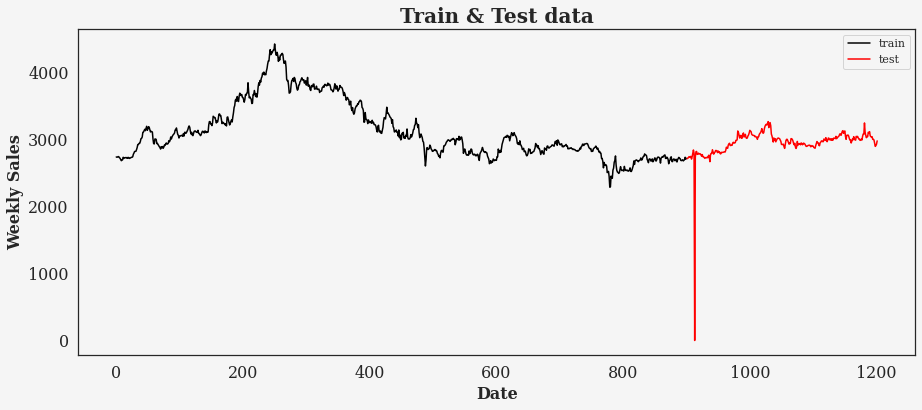

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(y_train, color='black')
plt.plot(y_test, color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [14]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [15]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 34.216132585392444
Root Mean squared Error - RMSE : 137.74069561400276


In [16]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (901, 1)
Test data prediction: (301, 1)


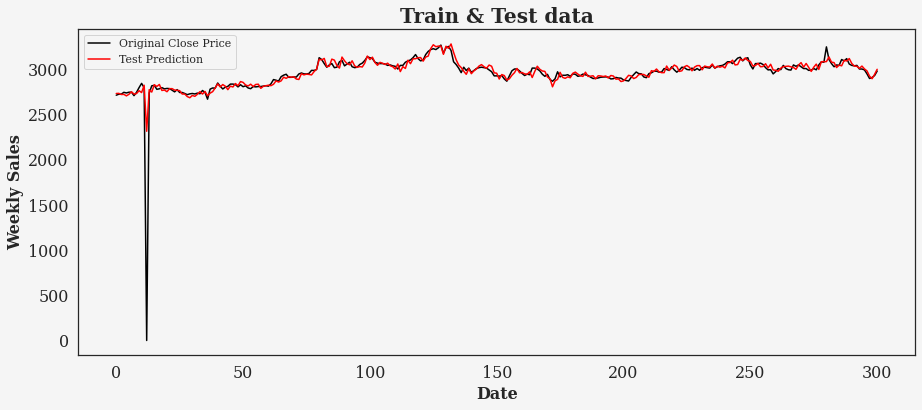

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(y_test.values, color='black')
plt.plot(test_predict, color='red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='best' ,labels = ('Original Close Price','Test Prediction'))

In [26]:
r2=np.round(r2_score(y_test,test_predict),2)
mse=np.round(mean_squared_error(y_test,test_predict),2)
mae=np.round(mean_squared_error(y_test,test_predict),2)
print('R2 Score : {}'.format(r2))
print('Mean Squared error : {}'.format(mse))
print('Mean Absolute error : {}'.format(mae))

R2 Score : 0.56
Mean Squared error : 18972.5
Mean Absolute error : 18972.5
